## Classification versus Regression

On day 1, we have tried to forecast a star rating as a number on a continuous scale: star ratings range from 1 to 5, but the way we trained our linear regression model, it sometimes returned a fractional prediction such as 4.37 stars. In general, prediction algorithms that output a number on a **continuous scale** are called **regression algorithms**. Linear regression is the most famous member of this family.

Sometimes all we really need to know is a **binary answer** to a question: Is a review bad or good? Is a user's comment abusive or not? Does a marketing email convert to a sale or not? Prediction algorithms that output either "true" or "false" (instead of a number) are called **classification algorithms**. While classification and regression are similar in many respects, there are also a couple of important differences: both regarding the algorithms we can use and how we evaluate them.

For example, assume that the only reviews we are really interested in are those with 1, 2 or 3 stars. Maybe we want to flag dissatisfied customers automatically so that we can review what went wrong and reach out to them. If we don't have the star ratings available for all customers, we want to be able to classify them as either satisfied or dissatisfied based on the textual content of their review alone. Let's introduce a variable ``D_train`` that is true if the customer is dissatisfied (1, 2 or 3 stars), and false if the customer is satisfied (4 stars or better):


In [4]:
%matplotlib inline
import urllib.request, os, gzip

datadir = './data/'

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

dataset = "Baby"
download_data(dataset, datadir)

Dataset Baby has already been downloaded to ./data/


In [5]:
import json

def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)

Loaded 160792 data for dataset Baby


In [6]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash'] % 10 <= 5]
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash'] % 10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash'] % 10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)

print("We have", len(baby_train), "training examples,", len(baby_valid),
      "validation examples, and", len(baby_test), "test examples.")

We have 96705 training examples, 32095 validation examples, and 31992 test examples.


In [7]:
from nltk.corpus import opinion_lexicon
import random

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10)))
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))

intersection = positive_words & negative_words
print("Words that appear in both sets: " + ", ".join(intersection))

Some positive words: revolutionary, sincere, spontaneous, eyecatching, motivated, lucrative, fabulously, capable, subsidizes, pleasurably
Some negative words: wariness, shrill, set-up, imminently, displeasing, hysterically, loopholes, inflationary, exclusion, dungeons
Words that appear in both sets: enviously, enviousness, envious


In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# English language stop words
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    """
    Split text into lower-case tokens, removing all-punctuation tokens and stopwords
    """
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    """
    Return the fraction of positive and negative words in a text
    """
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.

In [9]:
import numpy

def dataset_to_matrix(data):
    """Extract our feature matrix from the dataset"""
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train)

In [10]:
def dataset_to_targets(data):
    """Extract our target array from the dataset"""
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)

In [11]:
def discretize_targets(Y):
    """
    Return true for each rating that is less or equal to 3.
    """
    return Y <= 3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100. * D_train.mean()))
print("Are the first ten customers dissatisfied?", D_train[:10])

The training data contains 21.440463 % dissatisfied customers
Are the first ten customers dissatisfied? [False False  True False False  True  True False False False]



A **simple classifier would be an algorithm that takes a review text and produces either `True` or `False` as an output**. While this is often already useful, it doesn't tell us how confident the classifier is about its predictions. Is the algorithm absolutely sure that the review is bad, or is it a 50-50 decision? We may want to handle these cases differently, since some of the algorithm's errors can be more dangerous than others. 

In general, a classification algorithm can make two different kinds of errors: **false positives** mean that we wrongly flag a satisfied review (``D == false``) as dissatisfied, while **false negatives** mean that we wrongly flag a dissatisfied review (``D == true``) as satisfied. Often we will use our classification algorithm only as a screening filter to flag candidates for manual review. A false positive means that the reviewer has to read a lot of good reviews and confirm that there isn't actually a need to take action.


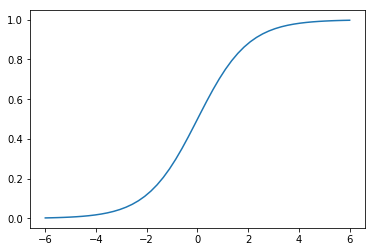

In [13]:
import pandas

points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points) + 1), index=points)
logistic_function.plot()

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, D_train)

# The predict_proba() method produces a matrix with two columns:
# - the first column contains the probability for the label being "false" (satisfied customer)
# - the second column contains the probability for the label being "true" (dissatisfied customer)
# - the sum of both columns is 1.

# We select:
# - the second column with [:,1]
# - the first column with [:,0]
# - the second row with [1,:], etc.

prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 15784
True rating = 1.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.999882
Features = 0.000000 / 1.000000
Review text = uncomfortable


In [15]:
analyze_training_example_2(min_prob2)

Training example number 10476
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000039
Features = 1.000000 / 0.000000
Review text = work perfect



### Intermediate Homework

Change the treshold from 0.5 to 0.2, and rerun the code:
- Give a commentary in plain English about how that changed [precision and recall][1]. 
- What does that mean? What is now included that wasn't before? 
- What part of it is good? What is bad from our Task perspective. 

Remember: our task was to identify **Dissatisfied** reviews.

[1]: https://en.wikipedia.org/wiki/Precision_and_recall

In [17]:
from sklearn.metrics import precision_score, recall_score

precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)

print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.602075 and recall = 0.095158


Precision as function of threshold:


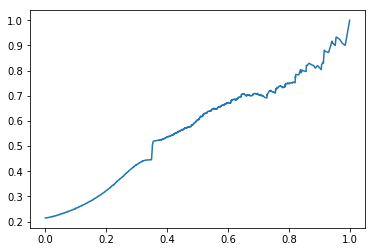

In [20]:
from sklearn.metrics import precision_recall_curve

all_precision2, all_recall2, all_thresh2 = precision_recall_curve(D_train, prob2_train)

print("Precision as function of threshold:")
pandas.Series(all_precision2[:-1], index=all_thresh2).plot()

Recall as function of threshold:


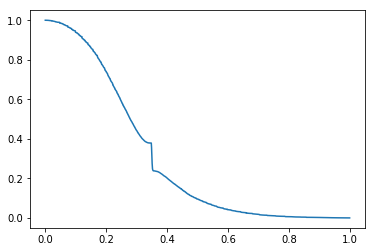

In [21]:
print("Recall as function of threshold:")
pandas.Series(all_recall2[:-1], index=all_thresh2).plot()

Recall as function of precision:


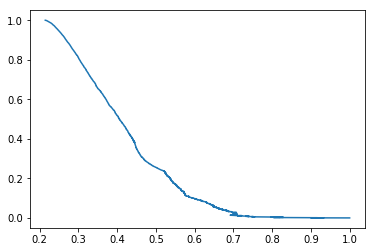

In [22]:
print("Recall as function of precision:")
pandas.Series(all_recall2[:-1], index=all_precision2[:-1]).plot()

Now the precision is 0.486546 and the recall is 0.159593


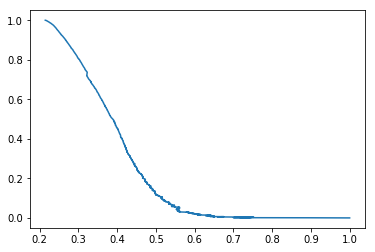

In [23]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train > 0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train, pred3_train)

print("Now the precision is %f and the recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(D_train, prob3_train)

pandas.Series(all_recall3[:-1], index=all_precision3[:-1]).plot()

[Chapter 6][1] of NLTK book describes what Naive-Bayes models are.

[1]: http://www.nltk.org/book/ch06.html

## TensorFlow

**Linear Regression with TensorFlow**


Step 1: Make sure you follow [installation guide of TensorFlow][1] and then you will be able to import it. 

**Note**: TensorFlow doesn't support Python 3.7 yet!

[1]: https://www.tensorflow.org/

In [27]:
import tensorflow as tf

feat_cols = [tf.feature_column.numeric_column(key="fpos"), tf.feature_column.numeric_column(key="fneg")]

model = tf.estimator.LinearRegressor(feature_columns=feat_cols)

get_training_data = tf.estimator.inputs.numpy_input_fn(
                        x = {"fpos" : X_train[:,0], "fneg" : X_train[:,1]},
                        y = Y_train, 
                        num_epochs=None, 
                        shuffle=True)

model.train(input_fn=get_training_data, steps=5000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_is_chief': True, '_master': '', '_session_config': None, '_task_type': 'worker', '_save_summary_steps': 100, '_tf_random_seed': None, '_service': None, '_save_checkpoints_steps': None, '_model_dir': '/tmp/tmp88oyigm2', '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f149a7be358>, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp88oyigm2/model.ckpt.
INFO:tensorflow:step = 1, loss = 2398.0
INFO:tensorflow:global_step/sec: 739.663
INFO:tensorflow:step = 101, loss = 259.408 (0.137 sec)
INFO:tensorflow:global_step/sec: 725.27
INFO:tensorflow:step = 201, loss = 194.693 (0.137 sec)
INFO:tensorflow:global_step/sec: 781.081
INFO:tensorflow:step = 301, lo

In [28]:
eval_training_data = tf.estimator.inputs.numpy_input_fn(
                        x = {"fpos":X_train[:,0], "fneg": X_train[:,1]},
                        num_epochs = 1, 
                        shuffle = False)

pred_train_tf = numpy.array([item['predictions'][0] for item in model.predict(input_fn=eval_training_data)])

mae_train_tf = mean_absolute_error(pred_train_tf, Y_train)

print("The mean absolute error on the training data is %f stars" % mae_train_tf)

INFO:tensorflow:Restoring parameters from /tmp/tmp88oyigm2/model.ckpt-5000
The mean absolute error on the training data is 0.843144 stars



## NLTK Built-In Sentiment Analyzer


In [25]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation

examples_negation = ["This product wasn't bad.",
                     "This is not a bad product.",
                     "This product was bad.",
                     "This is a bad product."]

for sentence in examples_negation:
    tokens_with_negation = mark_negation(word_tokenize(sentence.lower()))
    print("Sentence =", sentence)
    print(tokens_with_negation)

negated_stopwords = set(x + "_NEG" for x in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)        # set union
    
def tokenize_with_negation(text):
    """
    Split text into lower-case tokens, removing all-punctuation tokens and stopwords
    """ 
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

print(baby_train[31]['reviewText'])
print()
print(tokenize_with_negation(baby_train[31]['reviewText']))

Sentence = This product wasn't bad.
['this', 'product', 'was', "n't", 'bad_NEG', '.']
Sentence = This is not a bad product.
['this', 'is', 'not', 'a_NEG', 'bad_NEG', 'product_NEG', '.']
Sentence = This product was bad.
['this', 'product', 'was', 'bad', '.']
Sentence = This is a bad product.
['this', 'is', 'a', 'bad', 'product', '.']
We bought these trucks for our 15 mo. old daughter and 4 mo. old son- We love them!  They are nesting which is fun for our daughter to look underneath the trucks to find the next one or they can stack one on top of the other to make a tower.  Perfect first trucks!  And they aren't too big- a perfect size!

['bought', 'trucks', 'mo', 'old', 'daughter', 'mo', 'old', 'son-', 'love', 'nesting', 'fun', 'daughter', 'look', 'underneath', 'trucks', 'find', 'next', 'one', 'stack', 'one', 'top', 'make', 'tower', 'perfect', 'first', 'trucks', "n't", 'big-_NEG', 'perfect_NEG', 'size_NEG']


In [26]:
all_positive_words = positive_words.union({x + "_NEG" for x in negative_words})
all_negative_words = negative_words.union({x + "_NEG" for x in positive_words})

def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    # count how many positive and negative words occur in the text
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_positive_words:
            count_pos += 1
        if t in all_negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:  # avoid division by zero
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example))
print(pos_neg_fraction_with_negation(neg_example))    

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [27]:
pos_example_neg = 'This is not a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example_neg = 'This is not a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example_neg))
print(pos_neg_fraction_with_negation(neg_example_neg))    

(0.0, 0.8571428571428571)
(0.8571428571428571, 0.0)


In [28]:
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item['reviewText'])) for item in data])

X_train_neg = dataset_to_matrix_with_neg(baby_train)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lreg_neg = LinearRegression().fit(X_train_neg, Y_train)
pred_train_neg = lreg_neg.predict(X_train_neg)
mae_train_with_neg = mean_absolute_error(pred_train_neg, Y_train)

print("Now the mean absolute error on the training data is %f stars" % mae_train_with_neg)

Now the mean absolute error on the training data is 0.815012 stars



## Random Forest Regressor


In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_neg = RandomForestRegressor().fit(X_train_neg, Y_train)
pred_train_rf_neg = rf_neg.predict(X_train_neg)
mae_train_rf_neg = mean_absolute_error(pred_train_rf_neg, Y_train)

print("A nonlinear regressor achieves a MAE of %f stars" % mae_train_rf_neg)

A nonlinear regressor achieves a MAE of 0.711644 stars



### Promising Models Shortlist 

**Note:**
> If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests). Once again, try to automate these steps as much as possible.

1. Train many quick and dirty models from different categories (e.g., Linear, Naive Bayes, SVM (Support Vector Machine), Random Forests, Neural nets, etc.) using standard parameters.
2. Measure and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm.
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering.
6. Have one or two more quick iterations of the five previous steps.
7. Shortlist the top three to five most promising models, preferring models that make different types of errors.

Source: p. 646. [Hands-on Machine Learning]

[1]: http://shop.oreilly.com/product/0636920052289.do

### Advanced Homework

- add features
- explain which features you chose, implement them, and write a commentary on your results
- feel welcome to use NLTK's built-in **Sentiment Analyzer** or any other research that you can find and understand